# Propagate spacecraft motion in Circular Restricted Three Body Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode, solve_ivp
from fastrk import BT8713M, RKCodeGen
from model_crtbp import crtbp
from timeit import timeit
from numba import njit

In [2]:
# generate code and import rk_prop function
# new module rk_bt8713m.py will be created (at first call) or loaded
# CRTBP is autonomous system i.e. equations doesn't have explicit time dependency

rk_module = RKCodeGen(BT8713M, autonomous=True).save_and_import()
rk_prop = rk_module.rk_prop

# after first run code above can be replaced by
# from rk_8713M import rk_prop

In [3]:
# Let's define Cauchy's problem:
# initial time and state for halo orbit

t0 = 0.
t1 = 3*np.pi
s0 = np.zeros(6)
s0[[0, 2, 4]] = 9.949942666080747733e-01, 4.732924802139452415e-03, -1.973768492871211949e-02
mc = np.array([3.001348389698916e-06])

In [4]:
# integration parameters
params = {'max_step': np.inf,
          'rtol': 1e-12,
          'atol': 1e-12,
          }


In [5]:
# use solve_ivp to solve Cauchy's problem
sol = solve_ivp(crtbp, (t0, t1), s0,
                method='DOP853', **params,
                args=(mc,))

In [6]:
arr = rk_prop(crtbp, s0, t0, t1, *params.values(), mc)

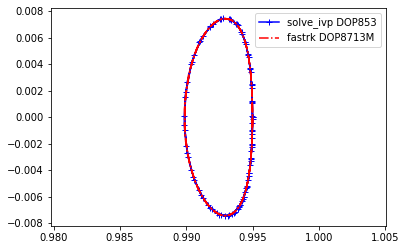

In [7]:
plt.plot(sol.y[0], sol.y[1], '-+b', label='solve_ivp DOP853')
plt.plot(arr[:, 1], arr[:, 2], '-.r', label='fastrk DOP8713M')
plt.axis('equal')
plt.legend()

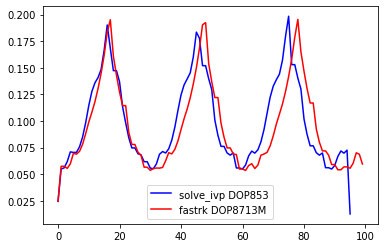

In [8]:
# step size plot
dop853_steps = sol.t[1:] - sol.t[:-1]
dop8713M_steps = arr[1:, 0] - arr[:-1, 0]

plt.plot(dop853_steps, 'b', label='solve_ivp DOP853')
plt.plot(dop8713M_steps, 'r', label='fastrk DOP8713M')
plt.legend()

In [9]:
loops = 1000
str0 = "solve_ivp(crtbp, (t0, t1), s0, method='DOP853', **params, args=(mc,))"
str1 = "rk_prop(crtbp, s0, t0, t1, *params.values(), mc)"

r0 = timeit(str0, number=loops, globals=globals())
r1 = timeit(str1, number=loops, globals=globals())

print(f"solve_ivp DOP853 time {r0:.2f}")
print(f"fastrk DOP8713M time {r1:.2f}")
print(f"speedup x {r0/r1:.2f}")

solve_ivp DOP853 time 20.88
fastrk DOP8713M time 0.83
speedup x 25.22


In [10]:
lst = []
def solout(t, s):
    lst.append([t, *s])
    return 0

dop853_prop = ode(crtbp)
dop853_prop.set_integrator('DOP853', **params)
dop853_prop.set_initial_value(s0, t0)
dop853_prop.set_f_params(mc)
dop853_prop.set_solout(solout)
dop853_prop.integrate(t1)

ode_arr = np.array(lst)

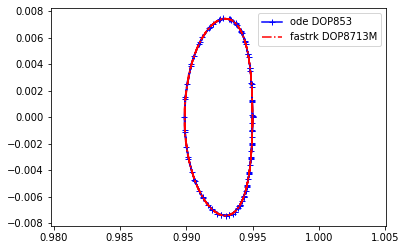

In [11]:
plt.plot(ode_arr[:, 1], ode_arr[:, 2], '-+b', label='ode DOP853')
plt.plot(arr[:, 1], arr[:, 2], '-.r', label='fastrk DOP8713M')
plt.axis('equal')
plt.legend()

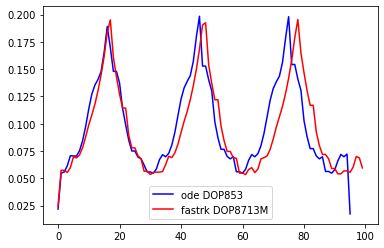

In [12]:
ode_steps = ode_arr[1:, 0] - ode_arr[:-1, 0]
plt.plot(ode_steps, 'b', label='ode DOP853')
plt.plot(dop8713M_steps, 'r', label='fastrk DOP8713M')
plt.legend()

In [13]:
# scipy.integrate.ode's fortran implementation of DOP853 works
# significantly faster with @njit-compiled function rather than @cfunc-compiled
njit_crtbp = njit(crtbp._pyfunc).compile('f8[:](f8, f8[:], f8[:])')

dop853_prop = ode(njit_crtbp)
dop853_prop.set_integrator('DOP853', **params)
dop853_prop.set_f_params(mc)
dop853_prop.set_solout(solout)

loops = 1000
str0 = "dop853_prop.set_initial_value(s0, t0).integrate(t1)"
str1 = "rk_prop(crtbp, s0, t0, t1, *params.values(), mc)"

r0 = timeit(str0, number=loops, globals=globals())
r1 = timeit(str1, number=loops, globals=globals())

print(f"ode DOP853 time {r0:.2f}")
print(f"fastrk DOP8713M time {r1:.2f}")
print(f"speedup x {r0/r1:.2f}")

ode DOP853 time 1.45
fastrk DOP8713M time 0.52
speedup x 2.80
